In [7]:
import geojson
import json, time, requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
from prophet import Prophet
from pmdarima import auto_arima
import pandas as pd
from pyproj import Transformer, Geod
from statsmodels.tsa.stattools import adfuller


c:\Users\Rohit\anaconda3\envs\devenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


### Getting coordinates of City

In [2]:
from geopy.geocoders import Nominatim

# Initialize Nominatim API
geolocator = Nominatim(user_agent="sample_app")

# Get location of a city
city = "St. Petersburg, Florida"
location = geolocator.geocode(city)

# Extract latitude and longitude
if location:
    city_lat = location.latitude
    city_long = location.longitude


#### Note: Since the raw data is 2GB large, we cannot track it in the repository. Kindly download it from the source mentioned in the README and place in a **/raw_data** folder in the root of the repository

In [ ]:
geojson_file = open("./raw_data/fire_data/USGS_Wildland_Fire_Combined_Dataset.json","r")
gj_data = geojson.load(geojson_file)
geojson_file.close()

In [3]:
#Utikity function to convert coordinates to valid format
def convert_ring_to_epsg4326(ring_data=None):
    converted_ring = list()
    #
    # We use a pyproj transformer that converts from ESRI:102008 to EPSG:4326 to transform the list of coordinates
    to_epsg4326 = Transformer.from_crs("ESRI:102008","EPSG:4326")
    # We'll run through the list transforming each ESRI:102008 x,y coordinate into a decimal degree lat,lon
    for coord in ring_data:
        lat,lon = to_epsg4326.transform(coord[0],coord[1])
        new_coord = lat,lon
        converted_ring.append(new_coord)
    return converted_ring

In [7]:
#    
#    The function takes two parameters
#        A place - which is coordinate point (list or tuple with two items, (lat,lon) in decimal degrees EPSG:4326
#        Ring_data - a list of decimal degree coordinates for the fire boundary
#
#    The function returns a list containing the shortest distance to the perimeter and the point where that is
#
def shortest_distance_from_place_to_fire_perimeter(place=None,ring_data=None):
    # convert the ring data to the right coordinate system
    ring = convert_ring_to_epsg4326(ring_data)    
    # create a epsg4326 compliant object - which is what the WGS84 ellipsoid is
    geodcalc = Geod(ellps='WGS84')
    closest_point = list()
    # run through each point in the converted ring data
    for point in ring:
        # calculate the distance
        d = geodcalc.inv(place[1],place[0],point[1],point[0])
        # convert the distance to miles
        distance_in_miles = d[2]*0.00062137
        # if it's closer to the city than the point we have, save it
        if not closest_point:
            closest_point.append(distance_in_miles)
            closest_point.append(point)
        elif closest_point and closest_point[0]>distance_in_miles:
            closest_point = list()
            closest_point.append(distance_in_miles)
            closest_point.append(point)
    return closest_point

### Processing fire data

In [8]:
def extract_start_date(data_str):
    start_date = None
    key = "Listed Wildfire Discovery Date(s): "
    key_start = data_str.find(key)
    if key_start != -1:
        # Slice the date right after the key, assuming a standard date format 'YYYY-MM-DD'
        date_extract = data_str[key_start + len(key): key_start + len(key) + 10]
        try:
            # Convert to datetime and add to dates list
            start_date = datetime.strptime(date_extract.strip(), '%Y-%m-%d').date()
        except ValueError:
            pass
    
    # Return the earliest date found
    return start_date

In [9]:
gj_data_processed= []
for i, feature in enumerate(tqdm(gj_data['features'], desc="Processing features")):
    try:
        fire_year = feature["attributes"]["Fire_Year"]
        usgs_id = feature["attributes"]["USGS_Assigned_ID"]
        fire_area_acres = feature["attributes"]["GIS_Acres"]
        datefield = feature["attributes"]["Listed_Fire_Dates"]
        fire_start_date = None

        #check year range
        if not (fire_year >= 1961 and fire_year <= 2021):
            continue
        
        #fetch date from datestring
        if not datefield:
            continue
        else:
            if datefield.startswith("Listed Other Fire Date(s)"):
                continue # no start or end date condition
            else:
                start_date = extract_start_date(datefield)
                if not start_date:
                    continue
                    
                #checking fire season months range
                if not(start_date >= datetime.strptime(f"{fire_year}-05-01".strip(), '%Y-%m-%d').date() and \
                    start_date <= datetime.strptime(f"{fire_year}-10-31".strip(), '%Y-%m-%d').date()):
                    continue

                if start_date.year != fire_year:
                    continue

                fire_start_date = start_date

        #get largest fire boundary
        if 'rings' in feature['geometry']:
            ring_data = feature['geometry']['rings'][0]
        elif 'curveRings' in feature['geometry']:
            ring_data = feature['geometry']['curveRings'][0]
        else:
            continue

        
        nearest_dist_miles = shortest_distance_from_place_to_fire_perimeter([city_lat, city_long], ring_data)

        #filter required distance. We need filter for 650 and 1800 seperately for 2 visualizations in the problem
        if nearest_dist_miles[0] > 1800:
            continue

        gj_data_processed.append(
            {
                "usgs_id" : usgs_id,
                "fire_year":fire_year,
                "fire_start_date":fire_start_date,
                "fire_area_acres":fire_area_acres,
                "distance_from_city_miles": nearest_dist_miles[0]
            }
        )
    except Exception as e:
        print(e)
        continue

Processing features: 100%|██████████| 135061/135061 [20:25<00:00, 110.24it/s]  


In [12]:
gj_data_within_650_miles = [ fire for fire in gj_data_processed if fire["distance_from_city_miles"] <= 650.0 ]

### AQI data retrieval and filtering

In [2]:
#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are some of the 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

In [3]:
#
#   Once we have the signup email, we can define two constants:
#
#   USERNAME - This should be the email address you sent the EPA asking for access to the API during sign-up
#   APIKEY   - This should be the authorization key they sent you
#
#   In this case I don't want to distribute my keys with the source of the notebook, so I wrote a key manager object that
#   helps track all of my API keys - a username and domain name retrieves the key. The key manager hides the keys on disk
#   separate from the code. Another common approach is to store your API key as an OS environment variable. You then use
#   a python package to extract that API key from the specific environment variable.
#
from apikeys.KeyManager import KeyManager
keyman = KeyManager()
#
#   Naturally, you should probably use the USERNAME that you used when you requested the API Key. I've used my email
#   address as my USERNAME when I added the API Key to the Key manager. This will look it up for me.
USERNAME = "rohitch@uw.edu"
key_info = keyman.findRecord(USERNAME,API_REQUEST_URL)
APIKEY = key_info[0]['key']
print(key_info[0]['description'])
#print(APIKEY)
#
#   Note: if you don't want to use the key manager to help manage your API keys, you can specify the values as constants
#   below. Just don't distribute the notebook without removing the constants or you'll be distributing your key too.
#
#USERNAME = "<the_email_address_you_sent_on_signup>"
#APIKEY = "<the_key_the_EPA_sent_you_in_email>"


AQS air data quality API


In [4]:
#   Particulate AQI pollutants PM10, PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101"
CITY_LOCATIONS = {
    'st. petersburg' : {'city'   : 'St. Petersburg',
                       'county' : 'Pinellas County',
                       'state'  : 'Florida',
                       'fips'   : '12103',
                       'latlon' : [27.7700, -82.6359] },
}

In [5]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


In [8]:
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['st. petersburg']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['st. petersburg']['fips'][2:]
request_data['param'] = AQI_PARAMS_PARTICULATES

mean_aqi_for_year={}

# request daily summary data. For our city data from the monitor starts from 1989
for year in tqdm(range(1989, 2021)):
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=f"{str(year)}0501", end_date=f"{str(year)}1031")

    if particulate_aqi["Header"][0]['status'] == "Success":
        aqis = [particulate["aqi"] for particulate in particulate_aqi['Data'] if particulate["aqi"]]
        mean_aqi_for_year[year] = np.mean(aqis)
    
    elif particulate_aqi["Header"][0]['status'].startswith("No data "):
        print("Looks like the response generated no data. You might take a closer look at your request and the response data.")
    else:
        print(json.dumps(particulate_aqi,indent=4))

100%|██████████| 32/32 [12:19<00:00, 23.10s/it]


### Calculating smoke impact estimate

In [20]:
mean_smoke_impact_estimate_for_year = {}

In [21]:
for fire in gj_data_within_650_miles:
    fire["smoke_impact_estimate"] = np.log1p(fire["fire_area_acres"] / fire['distance_from_city_miles'])

    if fire["fire_year"] not in mean_smoke_impact_estimate_for_year:
        mean_smoke_impact_estimate_for_year[fire["fire_year"]] = [fire["smoke_impact_estimate"]]
    else:
        mean_smoke_impact_estimate_for_year[fire["fire_year"]].append(fire["smoke_impact_estimate"])


### Averaging smoke estimates across the fire season

In [22]:
for year in mean_smoke_impact_estimate_for_year:
    mean_smoke_impact_estimate_for_year[year] = np.mean(mean_smoke_impact_estimate_for_year[year])

### Forecasting future smoke estimates

In [23]:
mean_smoke_impact_df = pd.DataFrame(list(mean_smoke_impact_estimate_for_year.items()), columns=['Year', 'Value'])
mean_smoke_impact_df.set_index('Year', inplace=True)

In [403]:
#checking stationary nature using ADF test, H0 : Series is non-stationary

adf_result = adfuller(mean_smoke_impact_df['Value'])
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

if adf_result[1] < 0.05:
    print("The series is stationary (reject null hypothesis).")
else:
    print("The series is non-stationary (fail to reject null hypothesis).")

ADF Statistic: -2.8567987675220428
p-value: 0.050607293716793234
The series is non-stationary (fail to reject null hypothesis).


#### **Note:** Since the time series is not stationary and doesn't have any seasonality we don't use auto-regressive models like ARIMA or SARIMAX

In [407]:
# Fit non-seasonal ARIMA model
model = auto_arima(mean_smoke_impact_df['Value'], seasonal=False, trace=True, stepwise=True, suppress_warnings=True)

# Print model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-27.186, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=20.024, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-17.646, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=0.099, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-27.361, Time=0.24 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-8.422, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-29.281, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-27.334, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-20.897, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-31.605, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-32.066, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-31.026, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-30.340, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-32.449, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-30.594, 

In [409]:
model.predict(n_periods=30)[0:20] # all similar flatlined predictions

c:\Users\Rohit\anaconda3\envs\devenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\Rohit\anaconda3\envs\devenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


50    0.227899
51    0.231680
52    0.232653
53    0.232903
54    0.232968
55    0.232984
56    0.232988
57    0.232989
58    0.232990
59    0.232990
60    0.232990
61    0.232990
62    0.232990
63    0.232990
64    0.232990
65    0.232990
66    0.232990
67    0.232990
68    0.232990
69    0.232990
dtype: float64

### Training FB Prophet

In [24]:
# Convert data to Prophet's required format
df_prophet = mean_smoke_impact_df.copy() 
df_prophet["Value"] = df_prophet["Value"]
df_prophet = df_prophet.reset_index().rename(columns={'Year': 'ds', 'Value': 'y'})
# Fit Prophet model
model_prophet = Prophet(changepoint_prior_scale=0.5)
model_prophet.fit(df_prophet)

# Make future predictions
future = model_prophet.make_future_dataframe(periods=90, freq="A")  # Forecast 30 periods ahead
forecast = model_prophet.predict(future)
forecast["year"] = forecast["ds"].dt.year
forecast = forecast[["year", "yhat", "yhat_lower", "yhat_upper"]]
forecast_future = forecast[(forecast["year"]>=2021) & (forecast["year"]<=2050)]
forecast_future.head()

17:45:11 - cmdstanpy - INFO - Chain [1] start processing
17:45:11 - cmdstanpy - INFO - Chain [1] done processing


,year,yhat,yhat_lower,yhat_upper
101,2021,0.239222,0.033049,0.453405
102,2022,0.211634,0.007382,0.415780
103,2023,0.182713,-0.016834,0.393039
104,2024,0.280121,0.076593,0.471948
105,2025,0.253907,0.061098,0.454062


In [27]:
forecast_future = forecast[(forecast["year"]>=2021) & (forecast["year"]<=2030)]

In [29]:
forecast_future.to_csv("future_smoke_estimate.csv", index=True)

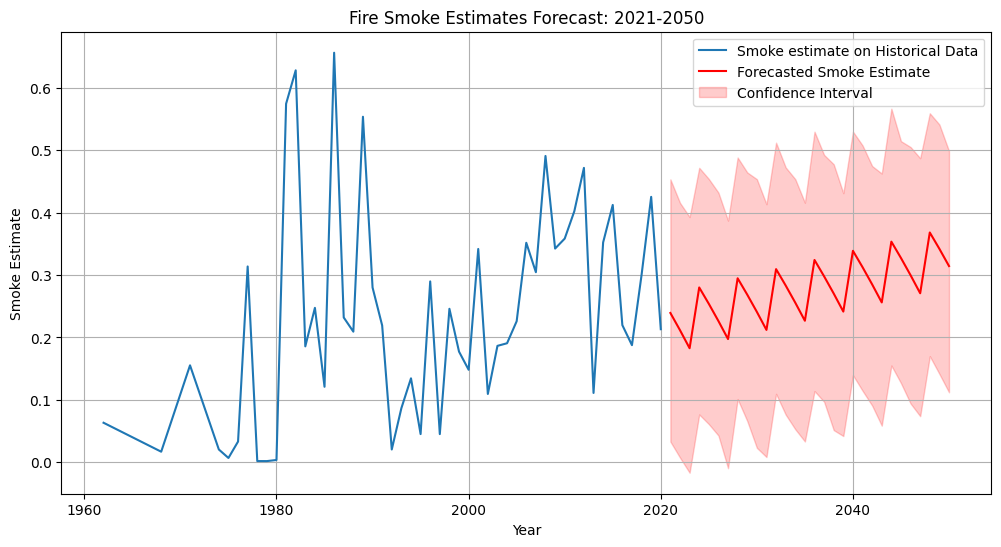

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(mean_smoke_impact_df, label='Smoke estimate on Historical Data')
plt.plot(forecast_future["year"], forecast_future["yhat"], label='Forecasted Smoke Estimate', color='red')
plt.fill_between(forecast_future["year"],forecast_future['yhat_lower'],forecast_future['yhat_upper'],color='red', alpha=0.2, label='Confidence Interval')
plt.title('Fire Smoke Estimates Forecast: 2021-2050')
plt.xlabel('Year')
plt.ylabel('Smoke Estimate')
plt.legend()
plt.grid(True)
plt.show()

### Finding correlation between smoke estimate and AQI

In [432]:
msi_year_filtered = [mean_smoke_impact_estimate_for_year[year] for year in mean_smoke_impact_estimate_for_year if year in mean_aqi_for_year]
corr = pd.Series(msi_year_filtered).corr(pd.Series((mean_aqi_for_year.values())))
corr

0.11705828977701575

### Histogram showing the number of fires occurring every 50 mile distance

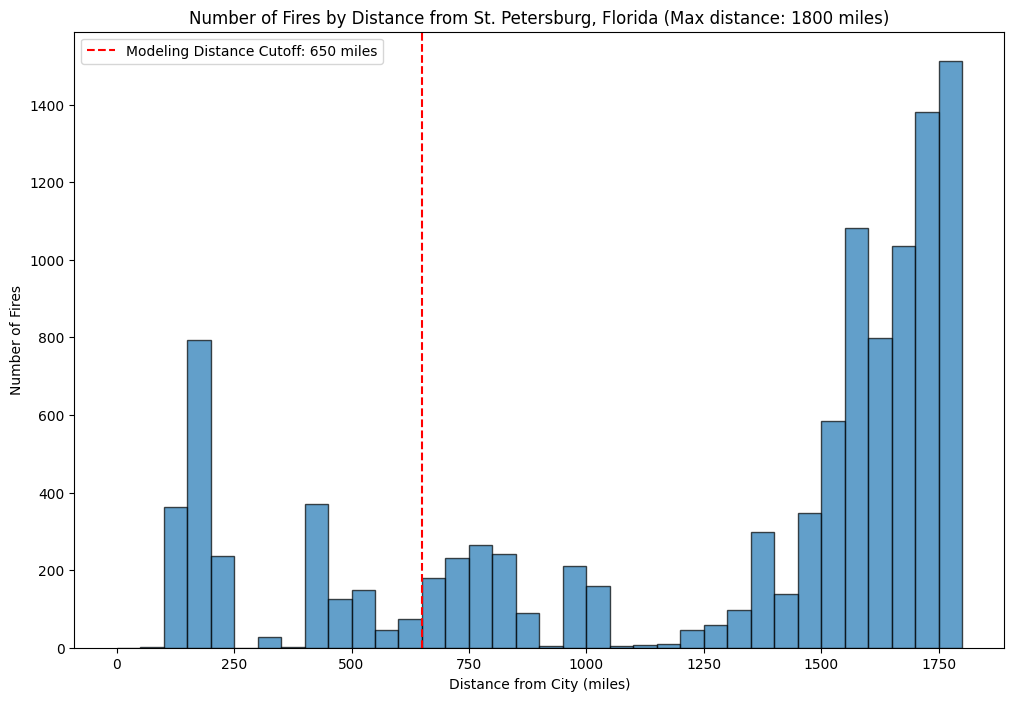

In [433]:

bins = list(range(0, 1850, 50))
cutoff_distance = 650
plt.figure(figsize=(12, 8))
plt.hist([fire["distance_from_city_miles"] for fire in gj_data_processed], bins=bins, edgecolor='black', alpha=0.7)
plt.xlabel("Distance from City (miles)")
plt.ylabel("Number of Fires")
plt.title(f"Number of Fires by Distance from {city} (Max distance: 1800 miles)")
plt.axvline(cutoff_distance, color='red', linestyle='--', label=f'Modeling Distance Cutoff: {cutoff_distance} miles')
plt.legend()

plt.show()

### Time series graph of total acres burned per year

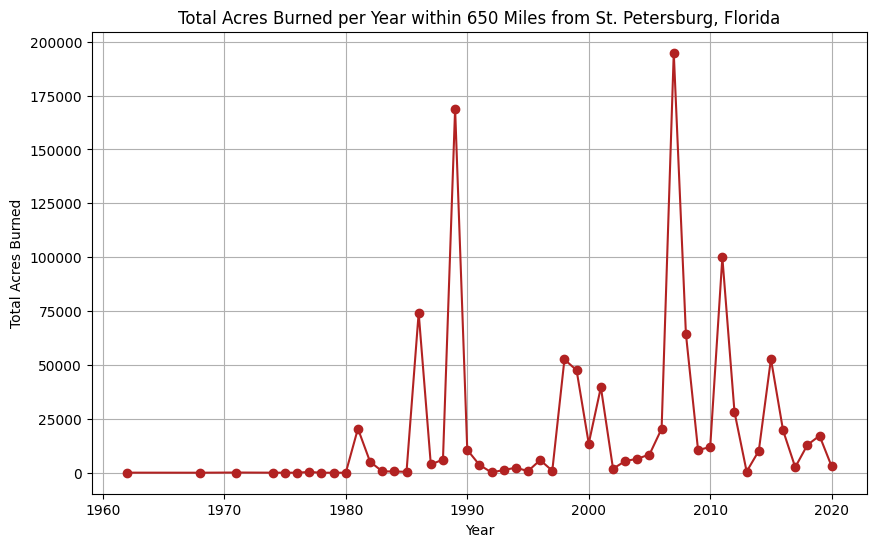

In [434]:
df = pd.DataFrame(gj_data_within_650_miles)
yearly_acres_burned = df.groupby('fire_year')['fire_area_acres'].sum()

plt.figure(figsize=(10, 6))
plt.plot(yearly_acres_burned.index, yearly_acres_burned.values, marker='o', color="firebrick", linestyle='-')

plt.xlabel("Year")
plt.ylabel("Total Acres Burned")
plt.title(f"Total Acres Burned per Year within {cutoff_distance} Miles from {city}")
plt.grid(True)

plt.show()

### Time series graph containing smoke estimates and AQI values

#### **Note:** 
Since the smoke impact estimatesare  only a relative metric we have used **min-max scaling** to scale up smoke estimate values in the similar 0-100 range for better visualization purposes and match with the range of the AQI values. This is just to show the trend more clearly.

In [212]:
def scale_to_range(values, new_min=0, new_max=100):
    min_val = min(values)
    max_val = max(values)
    
    scaled_values = [(new_max - new_min) * (value - min_val) / (max_val - min_val) + new_min for value in values]
    
    return scaled_values

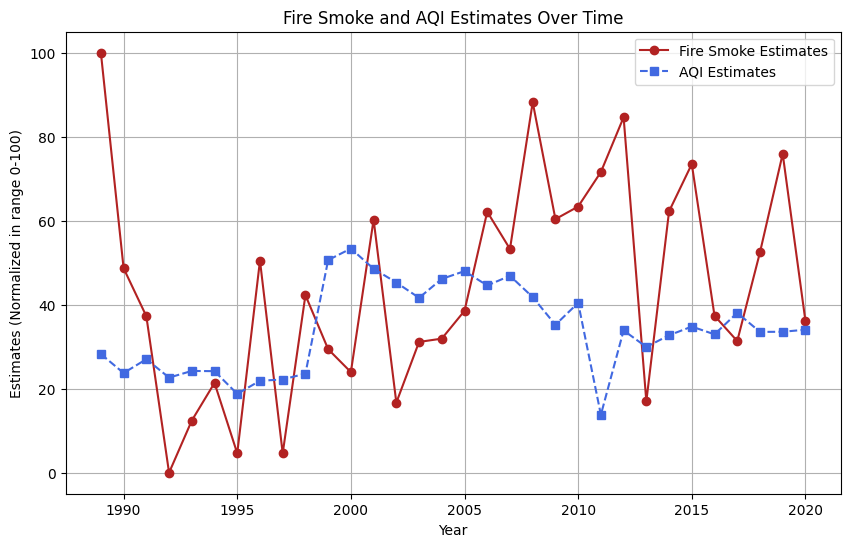

In [435]:
plt.figure(figsize=(10, 6))

years = list(mean_aqi_for_year.keys())
plt.plot(years, scale_to_range(msi_year_filtered), color='firebrick', marker='o', label='Fire Smoke Estimates')

plt.plot(years, mean_aqi_for_year.values(), color='royalblue', marker='s', linestyle='--', label='AQI Estimates')

plt.xlabel("Year")
plt.ylabel("Estimates (Normalized in range 0-100)")
plt.title("Fire Smoke and AQI Estimates Over Time")
plt.legend()

plt.grid(True)
plt.show()